## Khai  báo thư viện

In [1]:
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Tiền xử lí

In [2]:
train = pd.read_csv('train1.csv') #tập train

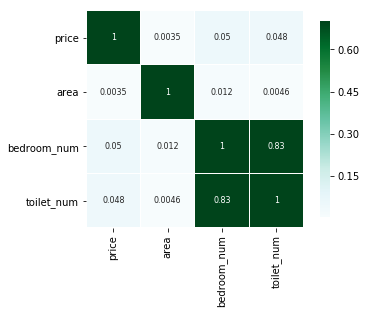

In [3]:
sns.heatmap(train.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},cbar_kws={"shrink": .9});

### Price

count    9.173000e+03
mean     4.176533e+09
std      3.684227e+09
min      5.000000e+08
25%      1.350000e+09
50%      3.200000e+09
75%      5.700000e+09
max      2.000000e+10
Name: price, dtype: float64


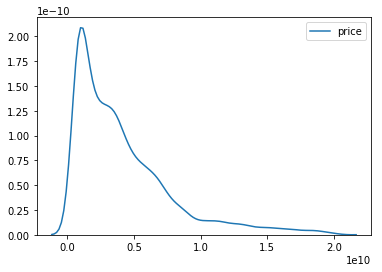

In [4]:
#Với giá, ta lọc giá thuộc 500 triệu đến 20 tỷ
train = train[(train.price>=5e8) & (train.price<=2e10)]
print(train['price'].describe())
sns.kdeplot(train.price)


### Area

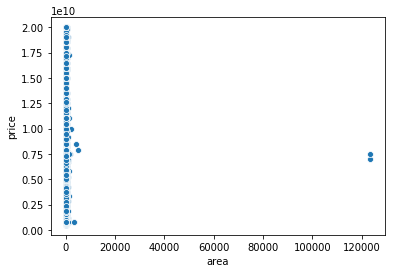

In [5]:
sns.scatterplot(x = train.area, y= train.price)

count    8932.000000
mean       72.184729
std        45.028824
min         1.000000
25%        42.000000
50%        60.000000
75%        87.000000
max       256.000000
Name: area, dtype: float64

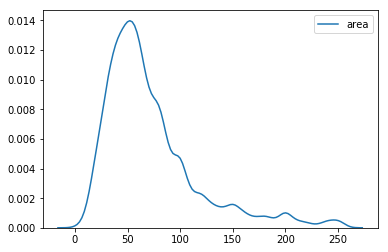

In [6]:
#Diện tích bị lệch khá nhiều sau khi visual nhỏ dần chọn được diện tích <260 m^2
train = train[train['area']<260]
sns.kdeplot(train.area)
train.area.describe()

In [7]:
train['area'] = train['area'].apply(lambda x: x if x < 260  else 260) #diện tích lớn hơn 260 cho vô 1 bin

### Bedroom_num

In [8]:
print("(số phòng ngủ, số lượng)")
for i in range(1,12):
    b1 = train[train['bedroom_num']< i]
    b2 = train[train['bedroom_num']< i+1]
    print((i,  b2.bedroom_num.count() - b1.bedroom_num.count()))
    
# sns.kdeplot(train.bedroom_num)

(số phòng ngủ, số lượng)
(1, 833)
(2, 3196)
(3, 1825)
(4, 1938)
(5, 546)
(6, 242)
(7, 55)
(8, 70)
(9, 21)
(10, 75)
(11, 122)


In [9]:
train['bedroom_num'] = train['bedroom_num'].apply(lambda x: x if x < 7  else 7) # lớn hơn 7 phòng ngủ cho vô 1 bin, số 11 có nghĩa là nhiều hơn 10 phòng ngủ

### Toilet_num

In [10]:
print("(số phòng vệ sinh, số lượng)")
for i in range(1,8):
    t1 = train[train['toilet_num']< i]
    t2 = train[train['toilet_num']< i+1]
    print((i,  t2.toilet_num.count() - t1.toilet_num.count()))

# sns.kdeplot(train.toilet_num)

(số phòng vệ sinh, số lượng)
(1, 1250)
(2, 2593)
(3, 1532)
(4, 886)
(5, 571)
(6, 162)
(7, 247)


In [11]:
train['toilet_num'] = train['toilet_num'].apply(lambda x: x if x < 6  else 6) # lớn hơn 6 phòng ngủ cho vô 1 bin số 7 có nghĩa là nhiều hớn 6 phòng vệ sinh

### Categorize and label for price

In [12]:
train_pre1 = train.copy()
train_pre1['type'] = train_pre1['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
train_pre1.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)

class CateCol(BaseEstimator, TransformerMixin):
    def __init__(self, col_name='price', _type=4):
        self.col_name = col_name
        self._type = _type
    
    def fit(self, X_df, y=None):
        details = X_df[self.col_name].describe()
        self._25 = details['25%']
        self._50 = details['50%']
        self._75 = details['75%']
        return self
    
    def to_cate(self, x):
        if self._type == 2:
            if x < self._50:
                return 0
            return 1
        
        if x < self._25:
            return 0
        if x < self._50:
            return 1
        if x < self._75:
            return 2
        return 3
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        res_df[self.col_name] = res_df[self.col_name].apply(lambda x: self.to_cate(x))  
        return res_df

In [13]:
train_pre1.legcal_doc.describe()

count                    7545
unique                      3
top       Đã có sổ đỏ/sổ hồng
freq                     7200
Name: legcal_doc, dtype: object

In [14]:
train_pre1.legcal_doc.unique()

array(['Đã có sổ đỏ/sổ hồng', nan, 'Giấy tay', 'Đang chờ bàn giao sổ'],
      dtype=object)

In [15]:
train_pre1.housing_feature.describe()

count           5142
unique             3
top       Hẻm xe hơi
freq            2261
Name: housing_feature, dtype: object

In [16]:
train_pre1.housing_feature.unique()

array(['Mặt tiền', 'Hẻm xe hơi', nan, 'Nở hậu'], dtype=object)

### Fill nan

- Fill `toilet_num` nan with `0.0`
- Fill `legcal_doc` nan with `Không có`
- Fill `housing_feature` nan with `Khác`
- Fill `bedroom_num` nan with `0.0`
- Fill `house_type` nan with `Khác`
- Fill `district`, `ward` and `street` nan `Khác`

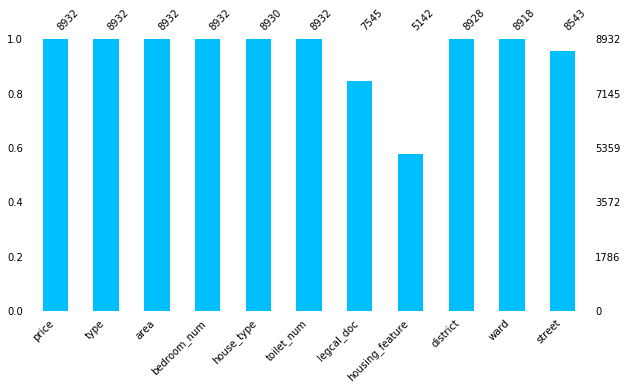

In [17]:
msn.bar(train_pre1, figsize=(10, 5), fontsize=10,color= 'deepskyblue')

In [18]:
class FillNA(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        res_df = X_df.copy()
        other_cols = ['housing_feature', 'house_type', 'street', 'district', 'ward']
        _0_cols = ['bedroom_num', 'toilet_num']
        for i in other_cols:
            res_df[i].fillna('Khác',inplace=True)
        for i in _0_cols:
            res_df[i].fillna(0.0,inplace=True)
        res_df['legcal_doc'].fillna('Không có', inplace=True)
        return res_df

In [19]:
fillna = FillNA()
train_pre = fillna.fit_transform(train_pre1)

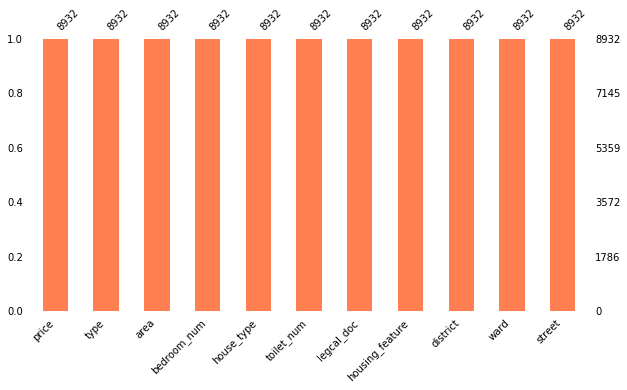

In [20]:
msn.bar(train_pre, figsize=(10, 5), fontsize=10,color='coral')

### Pipeline for preprocessing

In [21]:
scaler = StandardScaler()

pp = Pipeline(steps=[('FillNA', FillNA()),
                    ('to_cate_price', CateCol(col_name='price', _type=2))])

train_preprocess = pp.fit_transform(train_pre1)
trainY = train_preprocess['price'].values
trainX = train_preprocess.drop(columns=['price'])

onehot = OneHotEncoder(handle_unknown='ignore')
trainX = onehot.fit_transform(trainX).toarray()
trainX = scaler.fit_transform(trainX)

In [22]:
val = pd.read_csv('val.csv') #tập val

val['type'] = val['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
val.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)
val['area'] = val['area'].apply(lambda x: x if x < 260  else 260) #diện tích lớn hơn 260 cho vô 1 bin
val['bedroom_num'] = val['bedroom_num'].apply(lambda x: x if x < 7  else 7) # lớn hơn 7 phòng ngủ cho vô 1 bin, số 11 có nghĩa là nhiều hơn 10 phòng ngủ
val['toilet_num'] = val['toilet_num'].apply(lambda x: x if x < 6  else 6) # lớn hơn 6 phòng ngủ cho vô 1 bin số 7 có nghĩa là nhiều hớn 6 phòng vệ sinh

val_preprocess = pp.transform(val)
valY = val_preprocess['price'].values
valX = val_preprocess.drop(columns=['price'])
valX = onehot.transform(valX).toarray()
valX = scaler.transform(valX)

### Huấn luyện mô hình

Nhóm chọn 4 mô hình Randomforest, Logistics regression, KNN, MLP.

In [23]:
clfs = [RandomForestClassifier(n_jobs=4),LogisticRegression(n_jobs=4), 
        KNeighborsClassifier(n_jobs=4), MLPClassifier(hidden_layer_sizes=5,tol=1e-3)]

for clf in clfs:
    print(clf)
    clf.fit(trainX, trainY)
    print('Train score:', clf.score(trainX, trainY))
    print('Val score:', clf.score(valX, valY))
    print('\n')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Train score: 0.9769368562472011
Val score: 0.7568317677198976


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Train score: 0.843819973130318
Val score: 0.7549103330486764


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform')
Train score: 0.78750559

### Chọn tham số

Với 4 mô hình trên nhóm chọn được 2 mô hình có kết quả cao là Random Forest và logistics Regression

bây giờ nhóm cho chạy thử các tham số trên mô hình này.

In [24]:
C_params = [0.0001, 0.0005, 0.001, 0.01, 0.1]
n_estimators_params = [1, 10, 50, 100, 500, 1000]
acc_vals_tree = []
acc_trains_tree = []

acc_vals_logis = []
acc_trains_logis = []

for n in n_estimators_params:
    clf = RandomForestClassifier(n_estimators=n, n_jobs=4)
    clf.fit(trainX, trainY)
    acc_trains_tree.append(clf.score(trainX, trainY))
    acc_vals_tree.append(clf.score(valX, valY))
    
for c in C_params:
    clf = LogisticRegression(C=c, n_jobs=4)
    clf.fit(trainX, trainY)
    acc_trains_logis.append(clf.score(trainX, trainY))
    acc_vals_logis.append(clf.score(valX, valY))

'Finish!'

'Finish!'

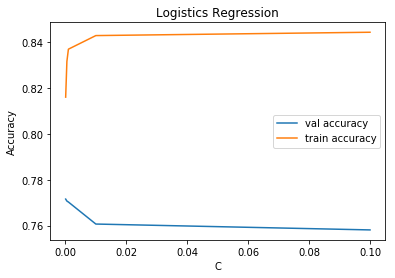

In [25]:
plt.plot(C_params, acc_vals_logis, label='val accuracy')
plt.plot(C_params, acc_trains_logis, label= 'train accuracy')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Logistics Regression")
plt.legend()
plt.show()

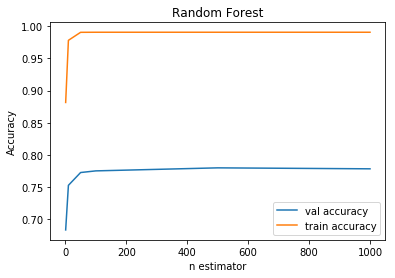

In [26]:
plt.plot(n_estimators_params, acc_vals_tree,label='val accuracy')
plt.plot(n_estimators_params, acc_trains_tree, label= 'train accuracy')

plt.xlabel('n estimator')
plt.ylabel('Accuracy')
plt.title("Random Forest")
plt.legend()
plt.show()

In [27]:
print('Train Accuracy Logistic:', acc_trains_logis)
print('Val Accuracy Logistic:', acc_vals_logis)
print('Train Accuracy Random Forest:', acc_trains_tree)
print('Val Accuracy Random Forest:', acc_vals_tree)

Train Accuracy Logistic: [0.8160546350201523, 0.8316166592028661, 0.8369905956112853, 0.8429243170622481, 0.8443797581728616]
Val Accuracy Logistic: [0.7715627668659265, 0.7707087959009393, 0.7702818104184458, 0.7606746370623398, 0.7581127241673783]
Train Accuracy Random Forest: [0.8815494849977609, 0.9779444693237797, 0.990371697268249, 0.9904836542767578, 0.9904836542767578, 0.9904836542767578]
Val Accuracy Random Forest: [0.6838172502134927, 0.7529888983774552, 0.7728437233134073, 0.7754056362083689, 0.7801024765157984, 0.7786080273270709]


In [28]:
ind_logis = np.argmax(acc_vals_logis)
ind_tree = np.argmax(acc_vals_tree)
print('Best c: {}, best val acc: {}'.format(C_params[ind_logis],acc_vals_logis[ind_logis]))
print('Best num_estimator: {}, best val acc: {}'.format(n_estimators_params[ind_tree],acc_vals_tree[ind_tree]))

Best c: 0.0001, best val acc: 0.7715627668659265
Best num_estimator: 500, best val acc: 0.7801024765157984


In [29]:
# Train all
train_all = pd.read_csv('train.csv')

train_all['type'] = train_all['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
train_all.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)
train_all['area'] = train_all['area'].apply(lambda x: x if x < 260  else 260) #diện tích lớn hơn 260 cho vô 1 bin
train_all['bedroom_num'] = train_all['bedroom_num'].apply(lambda x: x if x < 7  else 7) # lớn hơn 7 phòng ngủ cho vô 1 bin, số 11 có nghĩa là nhiều hơn 10 phòng ngủ
train_all['toilet_num'] = train_all['toilet_num'].apply(lambda x: x if x < 6  else 6) # lớn hơn 6 phòng ngủ cho vô 1 bin số 7 có nghĩa là nhiều hớn 6 phòng vệ sinh

train_all_preprocess = pp.transform(train_all)
trainY = train_all_preprocess['price'].values
trainX = train_all_preprocess.drop(columns=['price'])
trainX = onehot.transform(trainX).toarray()
trainX = scaler.transform(trainX)

# Train
clf = RandomForestClassifier(n_estimators=n_estimators_params[ind_tree], n_jobs=4)
clf.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
test = pd.read_csv('test.csv')

test['type'] = test['type'].apply(lambda x: x if x == 'Môi giới' else 'Khác')
test.drop(columns=['time','link','address',
                     'title','city','description',
                     'block_name','total_floor','direction'], inplace=True)
test['area'] = test['area'].apply(lambda x: x if x < 260  else 260) #diện tích lớn hơn 260 cho vô 1 bin
test['bedroom_num'] = test['bedroom_num'].apply(lambda x: x if x < 7  else 7) # lớn hơn 7 phòng ngủ cho vô 1 bin, số 11 có nghĩa là nhiều hơn 10 phòng ngủ
test['toilet_num'] = test['toilet_num'].apply(lambda x: x if x < 6  else 6) # lớn hơn 6 phòng ngủ cho vô 1 bin số 7 có nghĩa là nhiều hớn 6 phòng vệ sinh

test_preprocess = pp.transform(test)
testY = test_preprocess['price'].values
testX = test_preprocess.drop(columns=['price'])
testX = onehot.transform(testX).toarray()
testX = scaler.transform(testX)

# Test
clf.score(testX, testY)

0.799098337559876